In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
2023-09-19 11:56:12.384917: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    AddChannel,
)

import torch


print_config()

Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
2023-09-19 14:28:45.114526: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/dhruvjignesh.shah001/anaconda3/envs/O/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.6.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.1
pandas version: 1.2.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [23]:
pip install --upgrade torch

     |████████████████████████████████| 619.9 MB 17 kB/s  eta 0:00:0122  |██                              | 39.6 MB 6.6 MB/s eta 0:01:29     |██▍                             | 45.4 MB 6.6 MB/s eta 0:01:28     |███▍                            | 65.7 MB 15.5 MB/s eta 0:00:36     |████                            | 77.9 MB 3.5 MB/s eta 0:02:36     |████                            | 79.1 MB 3.5 MB/s eta 0:02:35     |████▎                           | 82.6 MB 3.5 MB/s eta 0:02:34     |████▌                           | 87.2 MB 3.5 MB/s eta 0:02:33     |████▉                           | 93.2 MB 13.3 MB/s eta 0:00:40     |█████                           | 98.0 MB 13.3 MB/s eta 0:00:40     |█████▍                          | 104.3 MB 5.8 MB/s eta 0:01:29     |█████▊                          | 109.8 MB 5.4 MB/s eta 0:01:36     |█████▊                          | 111.6 MB 2.8 MB/s eta 0:02:59     |█████▉                          | 112.7 MB 2.8 MB/s eta 0:02:59     |██████                          | 1

  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs000000000006c2a300000001'

Note: you may need to restart the kernel to use updated packages.


In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpv8ny4e0p


In [3]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["img", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["img"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["img", "label"], source_key="img"),
        Orientationd(keys=["img", "label"], axcodes="RAS"),
        Spacingd(
            keys=["img", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["img", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["img", "label"],
            label_key="label",
            spatial_size=(512, 512, 384),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="img",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["img", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["img", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["img", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["img", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["img"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        #LoadImaged(keys=["img", "label"], ensure_channel_first=True),
        #ScaleIntensityRanged(keys=["img"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["img", "label"], source_key="img"),
        #Orientationd(keys=["img", "label"], axcodes="RAS"),
        #Spacingd(
         #   keys=["img", "label"],
          #  pixdim=(1.5, 1.5, 2.0),
           # mode=("bilinear", "nearest"),
        #),
        EnsureTyped(keys=["img", "label"], device=device, track_meta=True),
    ]
)

In [4]:
padded_data_path = ''
json_list = "data_ESUS.json"
roi = (128, 128, 384)

In [5]:
roi[0]

128

In [6]:
datasets = padded_data_path + json_list
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    cache_num=24,
    cache_rate=1.0,
    num_workers=1,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6418.22it/s]


In [7]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=14,
    use_checkpoint=True,
).to(device)

In [9]:
from monai.losses import DiceCELoss

In [10]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()


In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_input_fname, val_label_fname = batch["img"], batch["label"]
            val_inputs = []
            val_labels = []
            for i in range(len(val_input_fname)):
                val_inputs_i = nrrd.read(val_input_fname[i])[0]
                val_labels_i = nrrd.read(val_label_fname[i])[0]
                val_input_mean = np.mean(val_inputs_i)
                val_input_std = np.std(val_inputs_i)
                val_inputs_i = (val_inputs_i - val_input_mean)/val_input_std
                val_inputs_i = torch.from_numpy(val_inputs_i).float()
                val_labels_i = torch.from_numpy(val_labels_i).float()
                
                val_inputs.append(val_inputs_i)
                val_labels.append(val_labels_i)
                
            # Concatenate the list of tensors into a single tensor along the batch dimension
            val_inputs = torch.stack(val_inputs, dim = 0).unsqueeze(1).to(device)
            val_labels = torch.stack(val_labels, dim = 0).unsqueeze(1).to(device)
            
            
            #val_inputs, val_labels = (batch["img"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                
                val_outputs = sliding_window_inference(val_inputs, (128, 128, 384), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x_filenames, y_filenames = batch["img"], batch["label"]
        x = []
        y = []
        for i in range(len(x_filenames)):
            # load the image and label data from the filenames
            x_i = nrrd.read(x_filenames[i])[0]
            y_i = nrrd.read(y_filenames[i])[0]
            x_mean = np.mean(x_i)
            x_std = np.std(x_i)
            x_i = (x_i - x_mean) / x_std 
            x_i = torch.from_numpy(x_i).float()
            y_i = torch.from_numpy(y_i).float()
        # Add to the list
            
            x.append(x_i)
            y.append(y_i)
            
        # Convert to torch tensors and move to GPU
        
        with torch.cuda.amp.autocast():
            x = torch.stack(x, dim=0).unsqueeze(1).to(device)
            y = torch.stack(y, dim=0).unsqueeze(1).to(device)
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [12]:
from tqdm import tqdm

In [13]:
import nrrd

In [14]:
max_iterations = 75
eval_num = 75
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                            | 0/199 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:34<05:28,  1.82s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:08<04:46,  1.78s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:43<04:15,  1.80s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:16<03:35,  1.76s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:52<03:01,  1.76s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:24<02:21,  1.71s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [03:59<01:51,  1.74s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:32<01:15,  1.72s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:07<00:44,  1.76s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:41<00:09,  1.80s/it]


Training (75 / 75 Steps) (loss=2.89955):  10%|███████████▌                                                                                                             | 76/793 [08:48<21:23:53, 107.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.804014265537262 Current Avg. Dice: 0.804014265537262


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:34<05:24,  1.80s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:08<04:51,  1.81s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:44<04:19,  1.83s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:18<03:37,  1.79s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:54<03:04,  1.79s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:28<02:24,  1.74s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [04:01<01:44,  1.63s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:34<01:17,  1.76s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:10<00:43,  1.75s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:42<00:08,  1.71s/it]


Training (150 / 75 Steps) (loss=3.19601):  19%|██████████████████████▋                                                                                                | 151/793 [17:30<19:11:59, 107.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9026970863342285 Current Avg. Dice: 0.9026970863342285


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:33<05:19,  1.77s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:06<04:39,  1.74s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:41<04:01,  1.70s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:14<03:35,  1.76s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:48<02:59,  1.74s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:21<02:23,  1.73s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [03:56<01:51,  1.75s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:30<01:18,  1.77s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:06<00:44,  1.79s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:40<00:08,  1.80s/it]


Training (225 / 75 Steps) (loss=2.61238):  28%|█████████████████████████████████▉                                                                                     | 226/793 [26:12<16:52:12, 107.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9160975217819214 Current Avg. Dice: 0.9160975217819214


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:34<05:24,  1.79s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:08<04:48,  1.79s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:44<04:14,  1.79s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:18<03:38,  1.79s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:54<03:04,  1.79s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:28<02:29,  1.80s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [04:04<01:54,  1.80s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:38<01:20,  1.82s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:14<00:44,  1.78s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:48<00:08,  1.79s/it]


Training (300 / 75 Steps) (loss=2.97122):  38%|█████████████████████████████████████████████▏                                                                         | 301/793 [35:02<14:59:25, 109.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.922842800617218 Current Avg. Dice: 0.922842800617218


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:33<05:20,  1.77s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:07<04:48,  1.79s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:42<04:00,  1.69s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:15<03:33,  1.75s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:50<03:02,  1.77s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:24<02:26,  1.76s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [04:00<01:54,  1.79s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:34<01:18,  1.79s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:10<00:44,  1.79s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:44<00:09,  1.83s/it]


Training (375 / 75 Steps) (loss=2.31505):  47%|████████████████████████████████████████████████████████▍                                                              | 376/793 [43:47<12:32:19, 108.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9240158200263977 Current Avg. Dice: 0.9240158200263977


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:33<05:11,  1.72s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:07<04:40,  1.74s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:41<04:09,  1.76s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:15<03:35,  1.76s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:51<03:05,  1.80s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:23<02:21,  1.71s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [03:58<01:49,  1.71s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:31<01:15,  1.71s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:05<00:43,  1.74s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:39<00:08,  1.79s/it]


Training (450 / 75 Steps) (loss=2.11777):  57%|███████████████████████████████████████████████████████████████████▋                                                   | 451/793 [52:29<10:09:25, 106.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.927216112613678 Current Avg. Dice: 0.927216112613678


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:25<04:30,  1.50s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [00:58<04:47,  1.79s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:31<03:57,  1.67s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:05<03:37,  1.78s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:39<02:39,  1.54s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:11<02:16,  1.64s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [03:44<01:52,  1.75s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:16<01:16,  1.73s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [04:52<00:42,  1.71s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:25<00:08,  1.74s/it]


Training (525 / 75 Steps) (loss=2.01410):  66%|██████████████████████████████████████████████████████████████████████████████▎                                       | 526/793 [1:00:55<7:36:26, 102.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9274383783340454 Current Avg. Dice: 0.9274383783340454


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:34<05:25,  1.80s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:08<04:48,  1.79s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:44<04:14,  1.79s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:18<03:34,  1.76s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:54<03:05,  1.80s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:28<02:23,  1.73s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [04:00<01:41,  1.58s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:32<01:12,  1.65s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:06<00:41,  1.66s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:37<00:08,  1.73s/it]


Training (600 / 75 Steps) (loss=1.95191):  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                            | 601/793 [1:09:34<5:39:32, 106.10s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9275431632995605 Current Avg. Dice: 0.9275431632995605


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:33<05:18,  1.76s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:07<04:48,  1.79s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:43<04:15,  1.80s/it]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [02:18<03:40,  1.81s/it]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [02:54<03:05,  1.80s/it]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [03:28<02:30,  1.81s/it]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [04:04<01:57,  1.84s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [04:38<01:18,  1.79s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [05:14<00:44,  1.79s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [05:48<00:08,  1.79s/it]


Training (675 / 75 Steps) (loss=1.72559):  85%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 676/793 [1:18:24<3:33:38, 109.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9275506734848022 Current Avg. Dice: 0.9275506734848022


Validate (0 / 10 Steps):   9%|████████████▊                                                                                                                                | 18/199 [00:33<05:20,  1.77s/it]


Validate (0 / 10 Steps):  19%|██████████████████████████▉                                                                                                                  | 38/199 [01:03<04:12,  1.57s/it]


Validate (0 / 10 Steps):  29%|████████████████████████████████████████▍                                                                                                    | 57/199 [01:16<01:12,  1.95it/s]


Validate (0 / 10 Steps):  39%|██████████████████████████████████████████████████████▌                                                                                      | 77/199 [01:25<01:00,  2.01it/s]


Validate (0 / 10 Steps):  48%|████████████████████████████████████████████████████████████████████                                                                         | 96/199 [01:36<00:50,  2.04it/s]


Validate (0 / 10 Steps):  58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 116/199 [01:48<00:53,  1.56it/s]


Validate (0 / 10 Steps):  68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 135/199 [02:08<01:16,  1.20s/it]


Validate (0 / 10 Steps):  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 155/199 [02:41<01:17,  1.77s/it]


Validate (0 / 10 Steps):  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/199 [03:17<00:45,  1.80s/it]


Validate (0 / 10 Steps):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/199 [03:51<00:09,  1.83s/it]


Training (750 / 75 Steps) (loss=1.62099):  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 751/793 [1:25:16<52:04, 74.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9275530576705933 Current Avg. Dice: 0.9275530576705933


Training (792 / 75 Steps) (loss=1.58721): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 793/793 [1:26:53<00:00,  6.57s/it]


<All keys matched successfully>

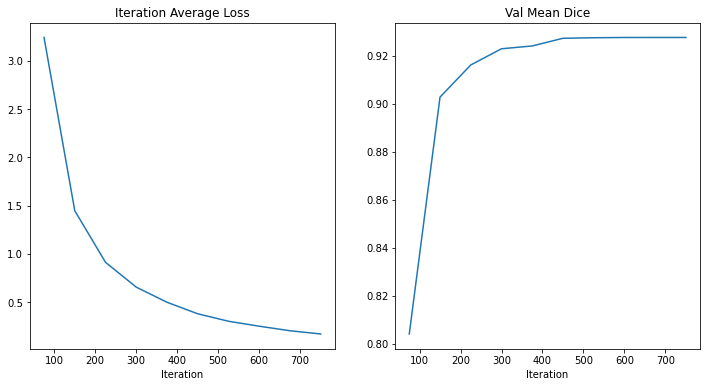

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [16]:
PATH = "model.pt"
torch.save(model.state_dict(), PATH)

In [25]:
PATH = "model.pt"
case_num = 4
slice_map = {
    "output_chunk_0.nrrd": 120,
    "output_chunk_50.nrrd": 60,
    "output_chunk_100.nrrd": 75,
    "output_chunk_150.nrrd": 32,
    "output_chunk_120.nrrd": 178,
    "output_chunk_225.nrrd": 86,
}
slice_map = tuple(slice_map)
model.load_state_dict(torch.load(PATH))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["img"])[1]
    test_img = []
    test_label = []
    img = val_ds[case_num]["img"]
    img = nrrd.read(img)[0]
    label = val_ds[case_num]["label"]
    label = nrrd.read(label)[0]
    
    test_img.append(torch.from_numpy(img).float())
    test_label.append(torch.from_numpy(label).float())
    val_inputs = torch.stack(test_img, dim = 0).unsqueeze(0).to(device)
    val_labels = torch.stack(test_label, dim = 0).unsqueeze(0).to(device)
    

    val_outputs = sliding_window_inference(val_inputs, (128, 128, 384), 4, model, overlap=0.8)
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 3, 1)
#     plt.title("image")
#     plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
#     plt.subplot(1, 3, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
#     plt.subplot(1, 3, 3)
#     plt.title("output")
    #print(type(slice_map[img]))
    #print(slice_map[img].shape)
    index = int(slice_map[img][0])
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, index])
    plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
z_slices = [0, 100, 200]
for z in z_slices:
    plt.imshow(data[:, :, z], cmap='gray')
    plt.title(f'Slice {z}')
    plt.show()

In [44]:
print(val_ds[4]["img"])

ChunkedImagesLabels/output_chunk_243.nrrd


In [15]:
PATH = "model.pt"
model.load_state_dict(torch.load(PATH))
model.eval()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=

In [16]:
test_files = [
    {
        "img": [
            "ChunkedImagesLabels/output_chunk_351.nrrd"
        ],
        "label": [
            "ChunkedImagesLabels/output_label_351.nrrd"
        ]
    }
]

In [28]:
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["img", "label"]),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)
    ]
)

In [17]:
test_ds = data.Dataset(data=test_files)

In [18]:
test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [19]:
model.to(device)

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=

In [20]:
model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)

In [21]:
with torch.no_grad():
    for batch_data in test_loader:
##        image = torch.stack(test_input_fname, dim = 0).unsqueeze(1).to(device)
        image = batch_data['img']
        
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

AttributeError: 'list' object has no attribute 'cuda'

In [39]:
with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data['img']
        image = nrrd.read(image)[0]

TypeError: expected str, bytes or os.PathLike object, not list